##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
!pip install -U -q tensorflow tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
# Installer le package kaggle
!pip install kaggle

In [6]:
!pip install -q kagglehub

import kagglehub
import pathlib
import tensorflow as tf
import numpy as np
import os

try:
    # Télécharger le dataset
    print("Téléchargement du dataset mini-speech-commands depuis Kaggle...")
    path = kagglehub.dataset_download("antfilatov/mini-speech-commands")

    print(f"Dataset téléchargé dans: {path}")

    # Utiliser le chemin
    data_dir = pathlib.Path(path)

    # Lister les commandes
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]

    print('Commands disponibles:', commands)
    print(f"Nombre de commandes: {len(commands)}")

    # Afficher quelques statistiques
    for command in commands:
        command_path = data_dir / command
        if command_path.is_dir():
            num_files = len(list(command_path.glob('*.wav')))
            print(f"  {command}: {num_files} fichiers audio")

except Exception as e:
    print(f"Erreur lors du téléchargement: {e}")
    print("Utilisation de la méthode de fallback...")

    # Fallback vers la méthode TensorFlow originale
    DATASET_PATH = 'data/mini_speech_commands'
    data_dir = pathlib.Path(DATASET_PATH)

    if not data_dir.exists():
        tf.keras.utils.get_file(
            'mini_speech_commands.zip',
            origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
            extract=True,
            cache_dir='.', cache_subdir='data'
        )

    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
    print('Commands:', commands)

Téléchargement du dataset mini-speech-commands depuis Kaggle...
Using Colab cache for faster access to the 'mini-speech-commands' dataset.
Dataset téléchargé dans: /kaggle/input/mini-speech-commands
Commands disponibles: ['mini_speech_commands']
Nombre de commandes: 1
  mini_speech_commands: 0 fichiers audio


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [11]:
import pathlib

# Vérifier le contenu du dossier parent
path = kagglehub.dataset_download("antfilatov/mini-speech-commands")
parent_dir = pathlib.Path(path)

print("Contenu du dossier téléchargé:")
for item in parent_dir.iterdir():
    if item.is_dir():
        num_files = len(list(item.glob('*')))
        print(f"📁 {item.name}: {num_files} éléments")
    else:
        print(f"📄 {item.name}")

# Chercher où sont les vraies données
def find_audio_files(start_path):
    start_path = pathlib.Path(start_path)
    audio_dirs = []

    for item in start_path.rglob('*'):  # cherche récursivement
        if item.is_dir():
            wav_files = list(item.glob('*.wav'))
            if wav_files:
                audio_dirs.append((item, len(wav_files)))

    return audio_dirs

print("\n🔍 Recherche des fichiers audio...")
audio_dirs = find_audio_files(parent_dir)
for dir_path, count in audio_dirs:
    print(f"🎵 {dir_path}: {count} fichiers .wav")

Using Colab cache for faster access to the 'mini-speech-commands' dataset.
Contenu du dossier téléchargé:
📁 mini_speech_commands: 9 éléments

🔍 Recherche des fichiers audio...
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/no: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/right: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/yes: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/left: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/go: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/down: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/stop: 1000 fichiers .wav
🎵 /kaggle/input/mini-speech-commands/mini_speech_commands/up: 1000 fichiers .wav


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [12]:
# Utilisez le chemin COMPLET trouvé par la recherche
data_dir = pathlib.Path("/kaggle/input/mini-speech-commands/mini_speech_commands")

# OU si vous voulez le trouver automatiquement :
path = kagglehub.dataset_download("antfilatov/mini-speech-commands")
data_dir = pathlib.Path(path) / "mini_speech_commands"

# Vérification
print("📁 Dossier utilisé:", data_dir)
print("✅ Existe:", data_dir.exists())

# Maintenant chargez le dataset correctement
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,  # ← CE chemin maintenant
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print("🎯 Label names:", label_names)

Using Colab cache for faster access to the 'mini-speech-commands' dataset.
📁 Dossier utilisé: /kaggle/input/mini-speech-commands/mini_speech_commands
✅ Existe: True
Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
🎯 Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [13]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from scipy import signal
import librosa
import librosa.display
from IPython.display import Audio, display
import seaborn as sns

# Configuration des plots
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

In [15]:
def load_and_analyze_audio(file_path):
    """Charge et analyse un fichier audio complet"""

    # Charger le fichier audio
    sr, audio_data = wavfile.read(file_path)

    # If stereo, take one channel
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]

    # Normalize
    audio_data = audio_data / np.max(np.abs(audio_data))

    return sr, audio_data

# Example with one of your files
file_path = "/kaggle/input/mini-speech-commands/mini_speech_commands/stop/4a4e28f1_nohash_0.wav"  # Replace with your path
sr, audio = load_and_analyze_audio(file_path)

print(f"Fréquence d'échantillonnage: {sr} Hz")
print(f"Durée: {len(audio)/sr:.2f} secondes")
print(f"Nombre d'échantillons: {len(audio)}")

# Listen to the audio
display(Audio(audio, rate=sr))

Fréquence d'échantillonnage: 16000 Hz
Durée: 1.00 secondes
Nombre d'échantillons: 16000


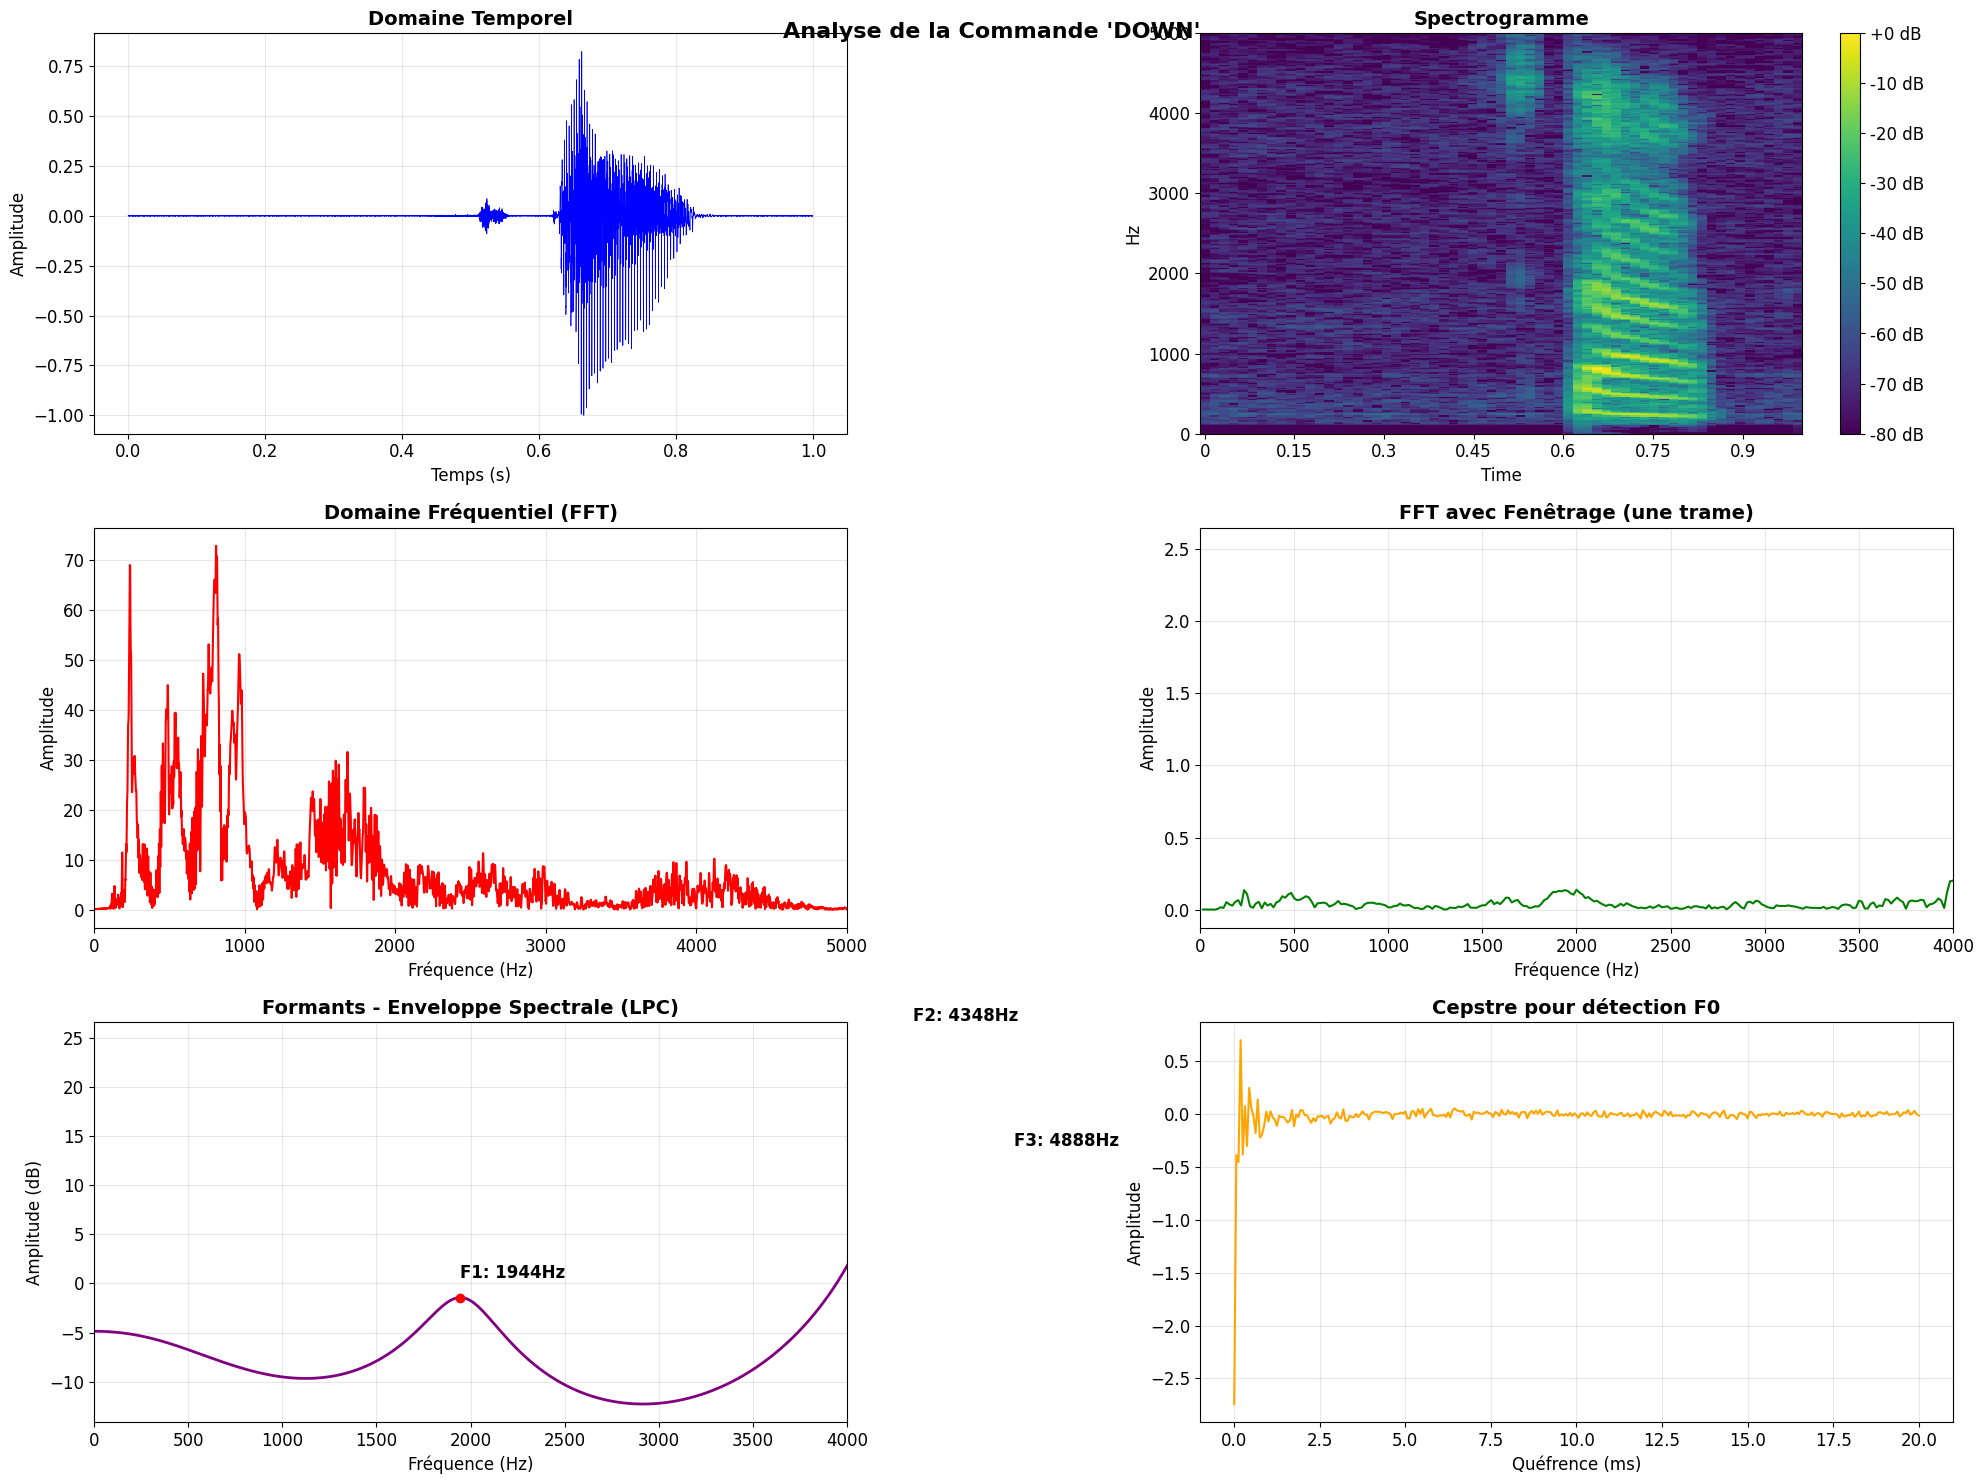

In [16]:
def plot_complete_audio_analysis(audio, sr, title="Analyse Audio Complète"):
    """Crée toutes les visualisations comme dans le cours"""

    fig = plt.figure(figsize=(20, 15))

    # 1. DOMAINE TEMPOREL (comme page 6)
    ax1 = plt.subplot(3, 2, 1)
    time = np.linspace(0, len(audio)/sr, len(audio))
    plt.plot(time, audio, 'b', linewidth=0.5)
    plt.title('Domaine Temporel', fontsize=14, fontweight='bold')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

    # 2. SPECTROGRAMME (comme pages 2-5)
    ax2 = plt.subplot(3, 2, 2)
    n_fft = 1024
    hop_length = 256
    spectrogram = librosa.stft(audio.astype(float), n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length,
                            x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogramme', fontsize=14, fontweight='bold')
    plt.ylim(0, 5000)  # Limite pour mieux voir les formants

    # 3. FFT - SPECTRE FRÉQUENTIEL (comme page 15)
    ax3 = plt.subplot(3, 2, 3)
    fft = np.fft.fft(audio)
    freqs = np.fft.fftfreq(len(fft), 1/sr)

    # Prendre seulement les fréquences positives
    positive_freq_idx = freqs > 0
    freqs_positive = freqs[positive_freq_idx]
    fft_positive = np.abs(fft[positive_freq_idx])

    plt.plot(freqs_positive, fft_positive, 'r')
    plt.title('Domaine Fréquentiel (FFT)', fontsize=14, fontweight='bold')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 5000)  # Limite pour voir les formants
    plt.grid(True, alpha=0.3)

    # 4. FENÊTRAGE et FFT sur une trame (comme pages 20-23)
    ax4 = plt.subplot(3, 2, 4)

    # Prendre une trame au milieu du signal
    frame_size = 1024
    start_idx = len(audio) // 2
    frame = audio[start_idx:start_idx + frame_size]

    # Appliquer une fenêtre de Hamming
    window = np.hamming(len(frame))
    frame_windowed = frame * window

    # FFT de la trame
    fft_frame = np.fft.fft(frame_windowed)
    freqs_frame = np.fft.fftfreq(len(fft_frame), 1/sr)

    positive_idx = freqs_frame > 0
    plt.plot(freqs_frame[positive_idx], np.abs(fft_frame[positive_idx]), 'g')
    plt.title('FFT avec Fenêtrage (une trame)', fontsize=14, fontweight='bold')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 4000)
    plt.grid(True, alpha=0.3)

    # 5. FORMANTS - Enveloppe spectrale (comme pages 15-17)
    ax5 = plt.subplot(3, 2, 5)

    # Calcul des formants avec LPC
    from scipy.signal import lfilter

    # Ordre LPC (typiquement 8-16 pour la parole)
    lpc_order = 12

    # Calcul des coefficients LPC
    # Méthode simplifiée
    r = np.correlate(frame_windowed, frame_windowed, mode='full')
    r = r[len(r)//2:]

    try:
        # Méthode autocorrelation pour LPC
        a = librosa.lpc(frame_windowed, order=lpc_order)

        # Réponse en fréquence
        w, h = signal.freqz(1, a, worN=2000)
        freq_response = np.abs(h)
        freq_axis = (w / np.pi) * (sr / 2)

        plt.plot(freq_axis, 20 * np.log10(freq_response + 1e-10), 'purple', linewidth=2)
        plt.title('Formants - Enveloppe Spectrale (LPC)', fontsize=14, fontweight='bold')
        plt.xlabel('Fréquence (Hz)')
        plt.ylabel('Amplitude (dB)')
        plt.xlim(0, 4000)
        plt.grid(True, alpha=0.3)

        # Détection des pics (formants)
        peaks, _ = signal.find_peaks(20 * np.log10(freq_response + 1e-10), height=-20, distance=100)
        for i, peak in enumerate(peaks[:3]):  # Premier 3 formants
            plt.plot(freq_axis[peak], 20 * np.log10(freq_response[peak] + 1e-10), 'ro')
            plt.text(freq_axis[peak], 20 * np.log10(freq_response[peak] + 1e-10) + 2,
                    f'F{i+1}: {freq_axis[peak]:.0f}Hz', fontweight='bold')

    except Exception as e:
        plt.text(0.5, 0.5, f'Erreur LPC: {e}', transform=ax5.transAxes, ha='center')

    # 6. CEPSTRE pour détection F0 (comme pages 36-40)
    ax6 = plt.subplot(3, 2, 6)

    # Calcul du cepstre
    spectrum = np.fft.fft(frame_windowed)
    log_spectrum = np.log(np.abs(spectrum) + 1e-10)
    cepstrum = np.fft.ifft(log_spectrum).real

    quefrency = np.arange(len(cepstrum)) / sr

    # Prendre la partie utile du cepstre
    max_quefrency = 0.02  # 20ms
    useful_idx = quefrency <= max_quefrency

    plt.plot(quefrency[useful_idx] * 1000, cepstrum[useful_idx], 'orange')
    plt.title('Cepstre pour détection F0', fontsize=14, fontweight='bold')
    plt.xlabel('Quéfrence (ms)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

    # Détection du pic cepstral (F0)
    cepstral_peaks, _ = signal.find_peaks(cepstrum[useful_idx], height=0.1, distance=10)
    if len(cepstral_peaks) > 1:
        f0_quefrency = quefrency[useful_idx][cepstral_peaks[1]]  # Premier pic après le pic à 0
        f0 = 1 / f0_quefrency if f0_quefrency > 0 else 0
        if 80 < f0 < 400:  # Plage réaliste pour F0
            plt.axvline(x=f0_quefrency * 1000, color='red', linestyle='--',
                       label=f'F0 = {f0:.1f} Hz')
            plt.legend()

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.show()

    return fig

# Appliquer l'analyse complète
fig = plot_complete_audio_analysis(audio, sr, "Analyse de la Commande 'STOP'")

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [26]:
def compare_commands(commands_to_analyze, data_dir):
    """Compare l'analyse de différentes commandes vocales - VERSION CORRIGÉE"""

    fig, axes = plt.subplots(len(commands_to_analyze), 3, figsize=(20, 5*len(commands_to_analyze)))

    # Si une seule commande, axes n'est pas un tableau 2D
    if len(commands_to_analyze) == 1:
        axes = axes.reshape(1, -1)

    for i, command in enumerate(commands_to_analyze):
        try:
            print(f"🔍 Recherche de fichiers pour la commande: {command}")

            # Construire le chemin correct
            command_dir = data_dir / command
            print(f"📁 Dossier cherché: {command_dir}")

            # Vérifier si le dossier existe
            if not command_dir.exists():
                print(f"❌ Dossier non trouvé: {command_dir}")
                continue

            # Lister les fichiers .wav
            wav_files = list(command_dir.glob("*.wav"))
            print(f"🎵 Fichiers trouvés: {len(wav_files)}")

            if wav_files:
                # Prendre le premier fichier
                file_path = wav_files[0]
                print(f"📄 Analyse du fichier: {file_path.name}")

                # Charger l'audio
                sr, audio = load_and_analyze_audio(str(file_path))

                # Domaine temporel
                time = np.linspace(0, len(audio)/sr, len(audio))
                axes[i, 0].plot(time, audio, 'b', linewidth=1)
                axes[i, 0].set_title(f'Temporel - {command.upper()}', fontweight='bold')
                axes[i, 0].set_xlabel('Temps (s)')
                axes[i, 0].set_ylabel('Amplitude')
                axes[i, 0].grid(True, alpha=0.3)

                # Spectrogramme
                n_fft = 1024
                hop_length = 256
                spectrogram = librosa.stft(audio.astype(float), n_fft=n_fft, hop_length=hop_length)
                spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

                img = librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length,
                                              x_axis='time', y_axis='hz', cmap='viridis', ax=axes[i, 1])
                axes[i, 1].set_title(f'Spectrogramme - {command.upper()}', fontweight='bold')
                axes[i, 1].set_ylabel('Fréquence (Hz)')
                axes[i, 1].set_ylim(0, 5000)
                plt.colorbar(img, ax=axes[i, 1])

                # Domaine fréquentiel
                fft = np.fft.fft(audio)
                freqs = np.fft.fftfreq(len(fft), 1/sr)
                positive_freq_idx = (freqs > 0) & (freqs < 5000)

                axes[i, 2].plot(freqs[positive_freq_idx], np.abs(fft[positive_freq_idx]), 'r', linewidth=1)
                axes[i, 2].set_title(f'Fréquentiel - {command.upper()}', fontweight='bold')
                axes[i, 2].set_xlabel('Fréquence (Hz)')
                axes[i, 2].set_ylabel('Amplitude')
                axes[i, 2].set_xlim(0, 5000)
                axes[i, 2].grid(True, alpha=0.3)

                print(f"✅ Commande '{command}' analysée avec succès!")

            else:
                print(f"❌ Aucun fichier .wav trouvé dans {command_dir}")
                axes[i, 0].text(0.5, 0.5, f'Fichiers non trouvés\n{command}',
                               transform=axes[i, 0].transAxes, ha='center', va='center')
                axes[i, 1].text(0.5, 0.5, f'Fichiers non trouvés\n{command}',
                               transform=axes[i, 1].transAxes, ha='center', va='center')
                axes[i, 2].text(0.5, 0.5, f'Fichiers non trouvés\n{command}',
                               transform=axes[i, 2].transAxes, ha='center', va='center')

        except Exception as e:
            print(f"❌ Erreur avec la commande {command}: {e}")
            import traceback
            traceback.print_exc()

            axes[i, 0].text(0.5, 0.5, f'Erreur\n{command}',
                           transform=axes[i, 0].transAxes, ha='center', va='center', color='red')
            axes[i, 1].text(0.5, 0.5, f'Erreur\n{command}',
                           transform=axes[i, 1].transAxes, ha='center', va='center', color='red')
            axes[i, 2].text(0.5, 0.5, f'Erreur\n{command}',
                           transform=axes[i, 2].transAxes, ha='center', va='center', color='red')

    plt.tight_layout()
    plt.show()

# Vérification préalable de la structure
def check_dataset_structure(data_dir):
    """Vérifie la structure du dataset"""
    print("🔍 Vérification de la structure du dataset...")
    print(f"📁 Dossier racine: {data_dir}")

    if not data_dir.exists():
        print("❌ Le dossier racine n'existe pas!")
        return False

    # Lister tous les sous-dossiers
    subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
    print(f"📊 Sous-dossiers trouvés: {len(subdirs)}")

    for subdir in subdirs:
        wav_files = list(subdir.glob("*.wav"))
        print(f"  📁 {subdir.name}: {len(wav_files)} fichiers .wav")

        # Afficher les premiers fichiers
        if wav_files:
            for i, file in enumerate(wav_files[:2]):
                print(f"     📄 {file.name}")
            if len(wav_files) > 2:
                print(f"     ... et {len(wav_files) - 2} autres fichiers")

    return len(subdirs) > 0

🎯 Chemin utilisé: /kaggle/input/mini-speech-commands/mini_speech_commands
✅ Dossier existe: True
🔍 Vérification de la structure du dataset...
📁 Dossier racine: /kaggle/input/mini-speech-commands/mini_speech_commands
📊 Sous-dossiers trouvés: 8
  📁 no: 1000 fichiers .wav
     📄 97f4c236_nohash_3.wav
     📄 6f3458b3_nohash_1.wav
     ... et 998 autres fichiers
  📁 right: 1000 fichiers .wav
     📄 cb2929ce_nohash_3.wav
     📄 dec73123_nohash_1.wav
     ... et 998 autres fichiers
  📁 yes: 1000 fichiers .wav
     📄 c08e5058_nohash_1.wav
     📄 2a89ad5c_nohash_1.wav
     ... et 998 autres fichiers
  📁 left: 1000 fichiers .wav
     📄 ab76ac76_nohash_1.wav
     📄 aeb99b1c_nohash_1.wav
     ... et 998 autres fichiers
  📁 go: 1000 fichiers .wav
     📄 cb2929ce_nohash_3.wav
     📄 df1d5024_nohash_2.wav
     ... et 998 autres fichiers
  📁 down: 1000 fichiers .wav
     📄 ad63d93c_nohash_1.wav
     📄 c22d3f18_nohash_0.wav
     ... et 998 autres fichiers
  📁 stop: 1000 fichiers .wav
     📄 97f4c236_no

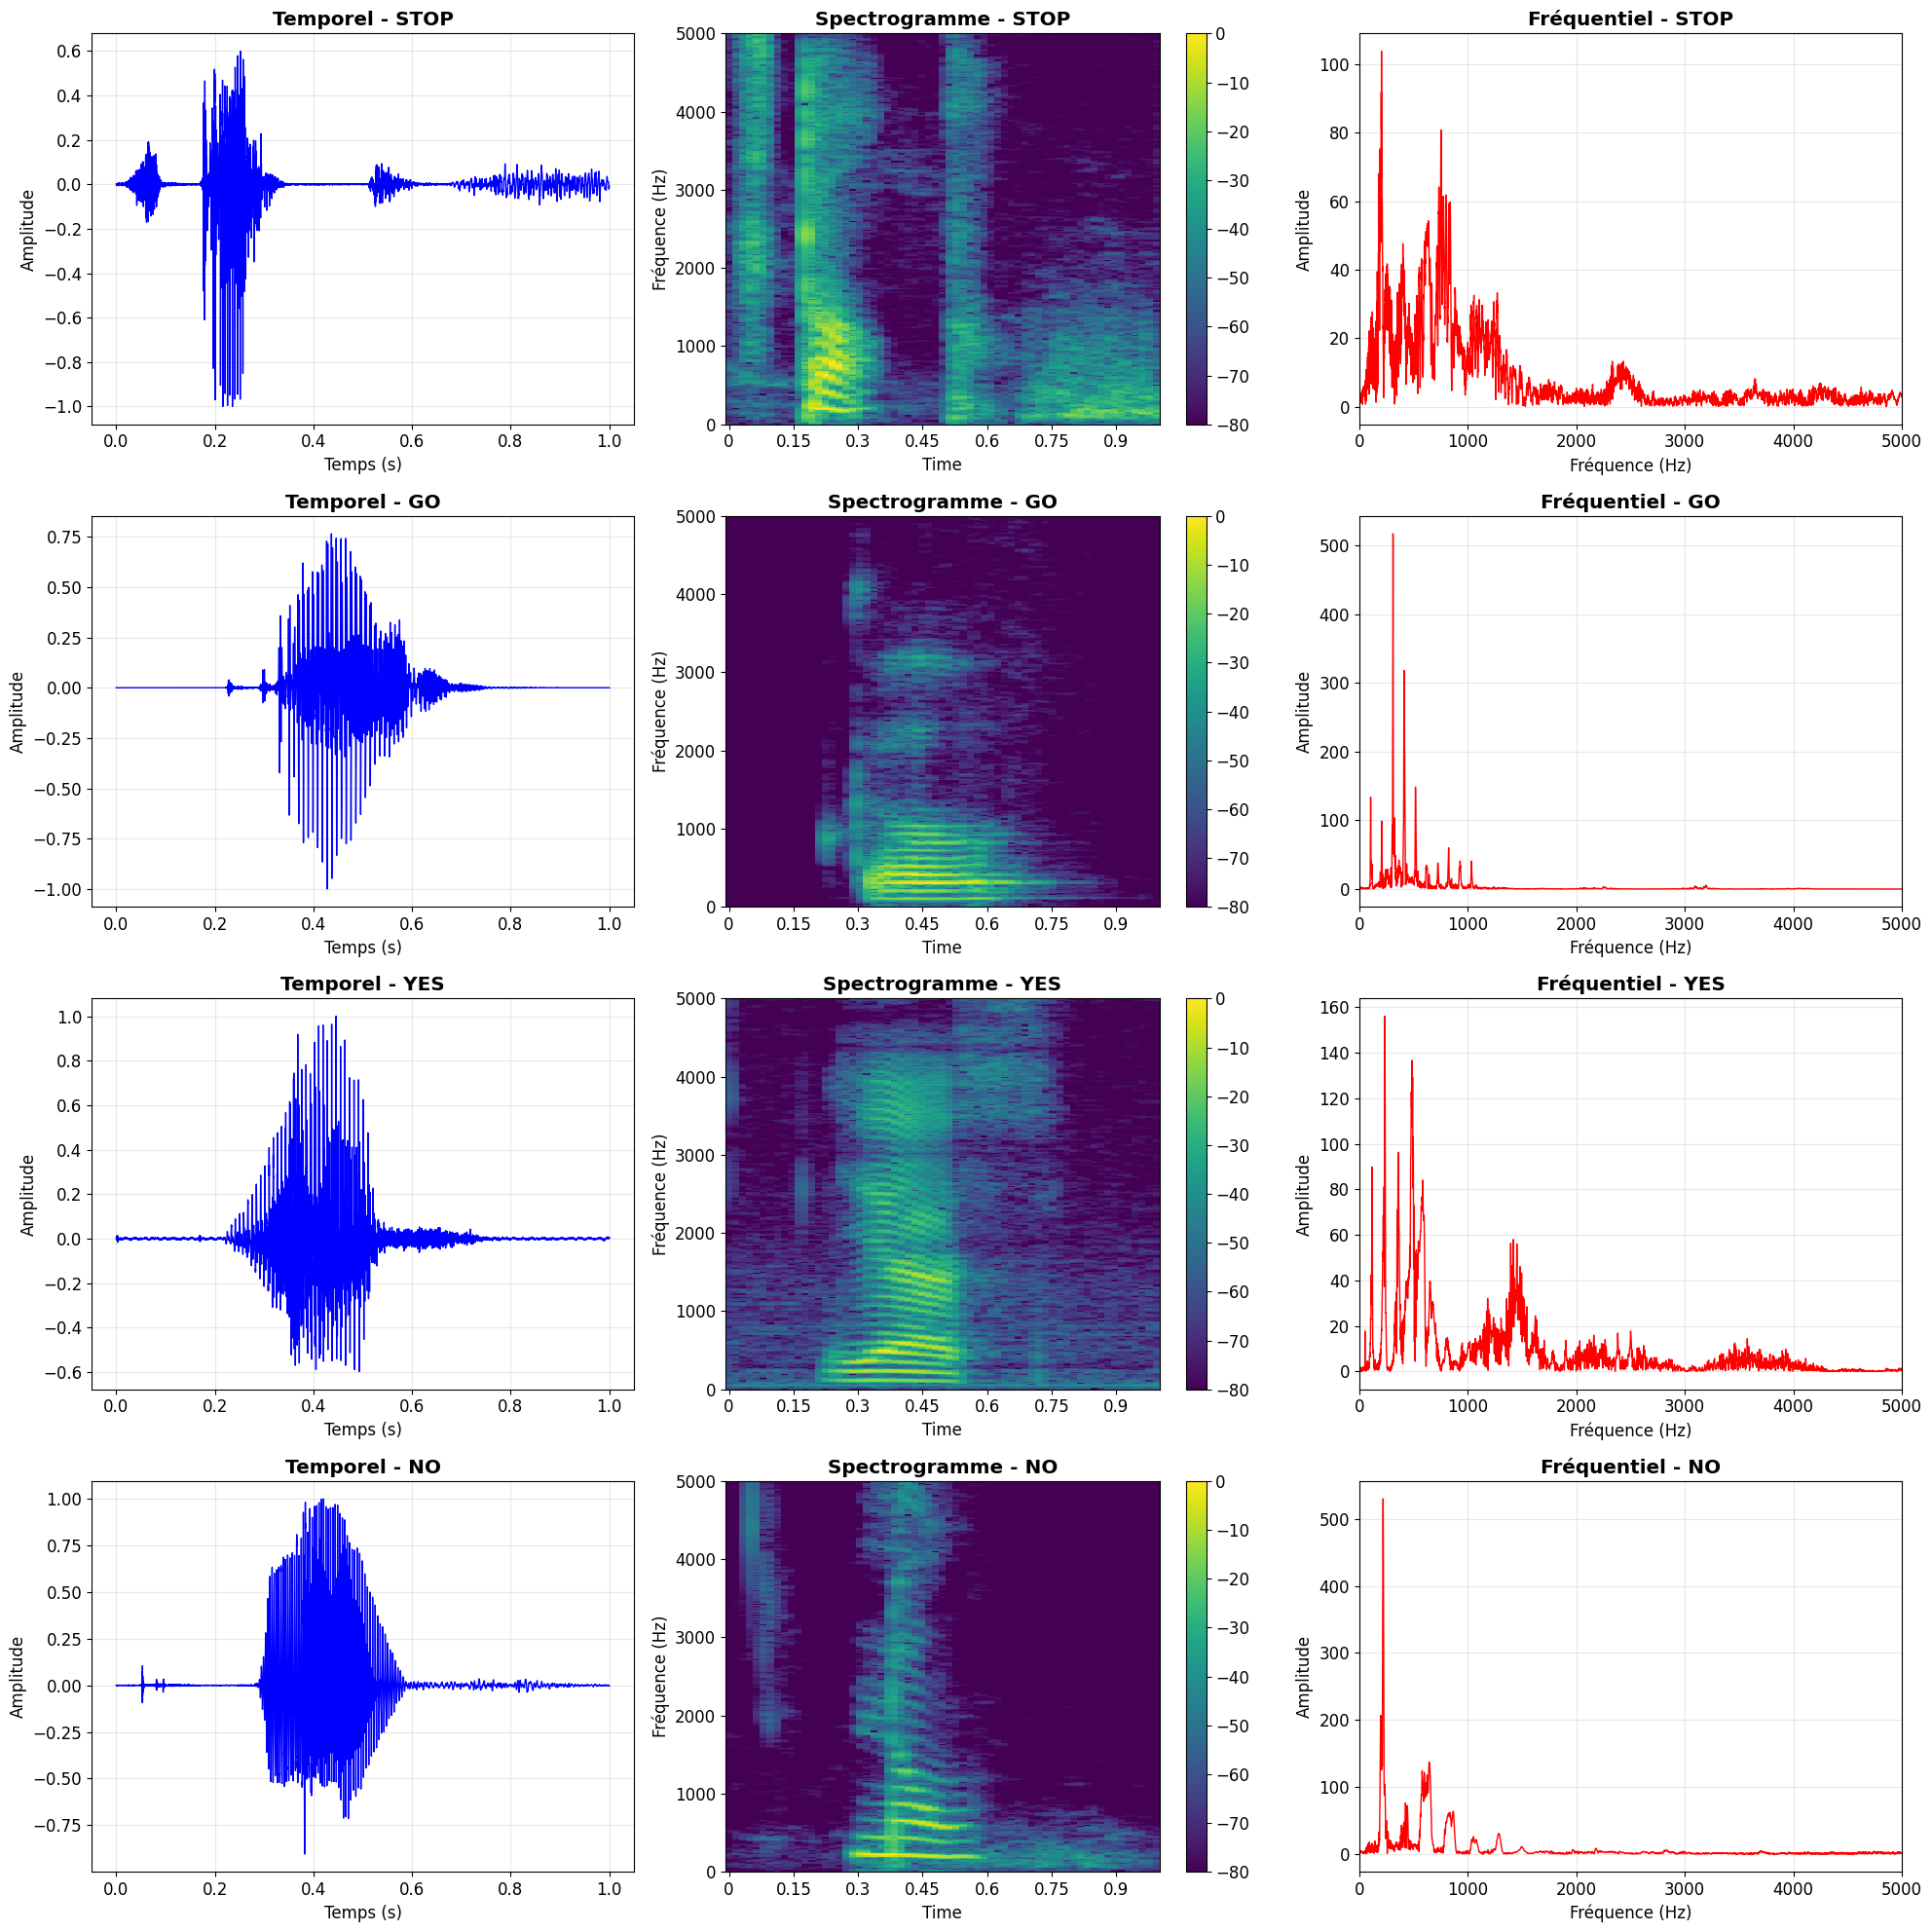

In [27]:
# D'ABORD, vérifier la structure
import pathlib

# Utilisez le bon chemin - IMPORTANT!
data_dir = pathlib.Path("/kaggle/input/mini-speech-commands/mini_speech_commands")

# OU si vous utilisez kagglehub:
# path = kagglehub.dataset_download("antfilatov/mini-speech-commands")
# data_dir = pathlib.Path(path) / "mini_speech_commands"

print(f"🎯 Chemin utilisé: {data_dir}")
print(f"✅ Dossier existe: {data_dir.exists()}")

# Vérifier la structure
check_dataset_structure(data_dir)

# MAINTENANT analyser quelques commandes
commands_to_analyze = ['stop', 'go', 'yes', 'no']
compare_commands(commands_to_analyze, data_dir)

🔍 Test de la commande: stop
✅ 1000 fichiers trouvés


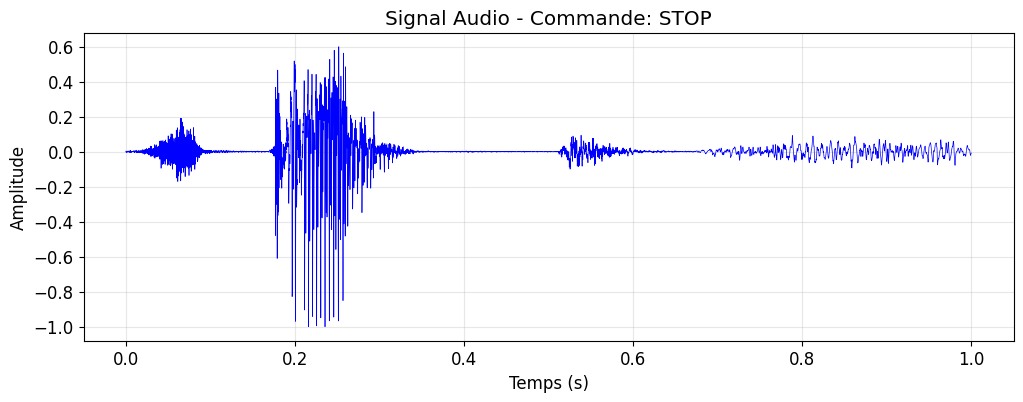

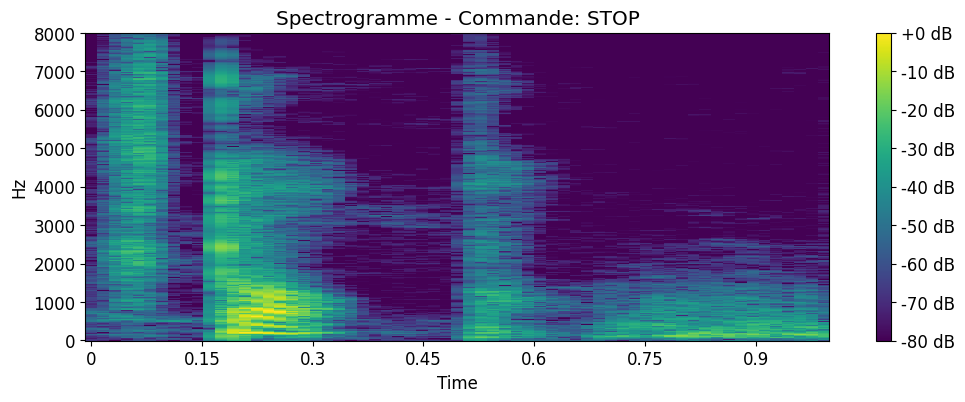

In [28]:
def quick_test_single_command(data_dir, command_name):
    """Test rapide sur une seule commande"""

    print(f"🔍 Test de la commande: {command_name}")

    command_dir = data_dir / command_name
    if not command_dir.exists():
        print(f"❌ Dossier non trouvé: {command_dir}")
        return

    wav_files = list(command_dir.glob("*.wav"))
    if not wav_files:
        print(f"❌ Aucun fichier .wav dans {command_dir}")
        return

    print(f"✅ {len(wav_files)} fichiers trouvés")

    # Analyser le premier fichier
    file_path = wav_files[0]
    sr, audio = load_and_analyze_audio(str(file_path))

    # Simple plot temporel
    plt.figure(figsize=(12, 4))
    time = np.linspace(0, len(audio)/sr, len(audio))
    plt.plot(time, audio, 'b', linewidth=0.5)
    plt.title(f'Signal Audio - Commande: {command_name.upper()}')
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Spectrogramme simple
    plt.figure(figsize=(12, 4))
    spectrogram = librosa.stft(audio.astype(float), n_fft=1024, hop_length=256)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=256,
                            x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogramme - Commande: {command_name.upper()}')
    plt.show()

# Test avec une seule commande
quick_test_single_command(data_dir, 'stop')

In [29]:
# Diagnostic complet du dataset
def full_diagnostic(data_dir):
    """Diagnostic complet de la structure des données"""

    print("🔍 DIAGNOSTIC COMPLET DU DATASET")
    print("=" * 50)

    if not data_dir.exists():
        print("❌ ERREUR: Le dossier principal n'existe pas!")
        print(f"   Chemin cherché: {data_dir}")
        return

    print(f"✅ Dossier principal trouvé: {data_dir}")

    # Lister TOUS les éléments
    all_items = list(data_dir.iterdir())
    print(f"📦 Total éléments dans le dossier: {len(all_items)}")

    for item in all_items:
        if item.is_dir():
            sub_items = list(item.iterdir())
            wav_files = list(item.glob("*.wav"))
            print(f"📁 {item.name}/")
            print(f"   ├─ Total éléments: {len(sub_items)}")
            print(f"   └─ Fichiers .wav: {len(wav_files)}")

            if wav_files:
                print(f"      Exemple: {wav_files[0].name}")
        else:
            print(f"📄 {item.name}")

    print("=" * 50)

# Exécuter le diagnostic
full_diagnostic(data_dir)

🔍 DIAGNOSTIC COMPLET DU DATASET
✅ Dossier principal trouvé: /kaggle/input/mini-speech-commands/mini_speech_commands
📦 Total éléments dans le dossier: 9
📁 no/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: 97f4c236_nohash_3.wav
📁 right/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: cb2929ce_nohash_3.wav
📁 yes/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: c08e5058_nohash_1.wav
📁 left/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: ab76ac76_nohash_1.wav
📄 README.md
📁 go/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: cb2929ce_nohash_3.wav
📁 down/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: ad63d93c_nohash_1.wav
📁 stop/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: 97f4c236_nohash_3.wav
📁 up/
   ├─ Total éléments: 1000
   └─ Fichiers .wav: 1000
      Exemple: 97f4c236_nohash_3.wav


In [ ]:
train_ds.element_spec

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Let's plot the training and validation loss curves to check how your model has improved during training:

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.